In [1]:
import scanpy as sc 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import bbknn
import scipy
import scipy.stats as stats
# sc.settings.set_figure_params(figsize=(5,4))
sc.settings.verbosity = 0 
sc.settings.set_figure_params(dpi_save=400, facecolor='white', fontsize=7, format='jpg')

In [2]:
adata = sc.read_h5ad('../data/v4-sub-fib.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 28134 × 3000
    obs: 'sample', 'sample_batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_poly'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_poly_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
val = []
for x in list(adata.obs['sample']):
    if x.startswith('AF'):
        val.append('AF')
    else:
        val.append('NAF')
adata.obs['sample_group'] = np.array(val)

In [7]:
adata

AnnData object with n_obs × n_vars = 28134 × 3000
    obs: 'sample', 'sample_batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_poly', 'sample_group'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_poly_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
df = pd.DataFrame(adata.obs.groupby(['sample_group', 'leiden_poly', 'sample']).count()['n_genes'])
df.columns = ['counts']

In [6]:
df

counts
sample_group leiden_poly sample        
AF           Fib1        AF-1      6068
                         AF-2      4856
                         AF-3      3437
                         NAF-1        0
                         NAF-2        0
                         NAF-3        0
             Fib2        AF-1        86
                         AF-2       225
                         AF-3      1247
                         NAF-1        0
                         NAF-2        0
                         NAF-3        0
             Fib3        AF-1       147
                         AF-2        47
                         AF-3        50
                         NAF-1        0
                         NAF-2        0
                         NAF-3        0
NAF          Fib1        AF-1         0
                         AF-2         0
                         AF-3         0
                         NAF-1     1805
                         NAF-2     3802
                         NAF-3     2826
             Fib2        AF-1         0
                         AF-2         0
                         AF-3         0
                         NAF-1      887
                         NAF-2      234
                         NAF-3     1121
             Fib3        AF-1         0
                         AF-2         0
                         AF-3         0
                         NAF-1      546
                         NAF-2      689
                         NAF-3       61

In [7]:
percent = []
for val in df.index:
    tp = df.loc[val[0],val[1],val[2]]['counts'].item()/ \
    df.groupby('leiden_poly').sum().loc[val[1],'counts'].item()
    percent.append(round(tp,3))
df['percent'] = percent
df = df[(~(df.loc[:,:,:]['percent'] ==0))]
df.to_csv('./df.csv', sep='\t')
df = pd.read_csv('./df.csv',sep='\t')

In [8]:
loc = {'AF':1,'NAF':2}
cts = list(np.unique(list(df['leiden_poly'])))

In [9]:
df

,sample_group,leiden_poly,sample,counts,percent
0,AF,Fib1,AF-1,6068,0.266
1,AF,Fib1,AF-2,4856,0.213
2,AF,Fib1,AF-3,3437,0.151
3,AF,Fib2,AF-1,86,0.023
4,AF,Fib2,AF-2,225,0.059
5,AF,Fib2,AF-3,1247,0.328
6,AF,Fib3,AF-1,147,0.095
7,AF,Fib3,AF-2,47,0.031
8,AF,Fib3,AF-3,50,0.032
9,NAF,Fib1,NAF-1,1805,0.079


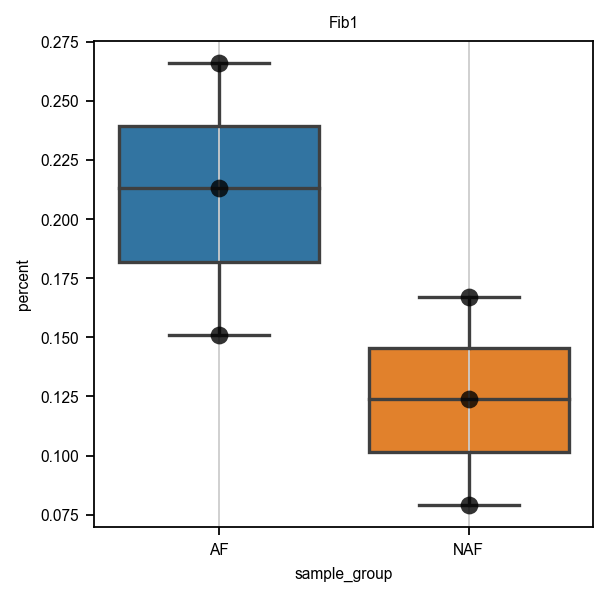

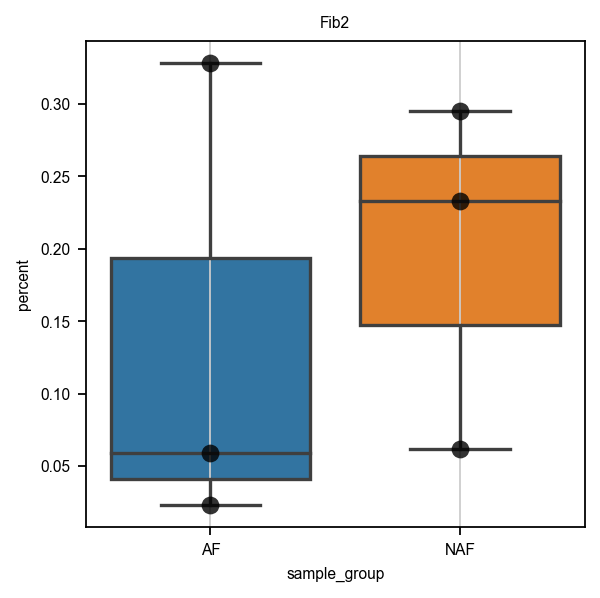

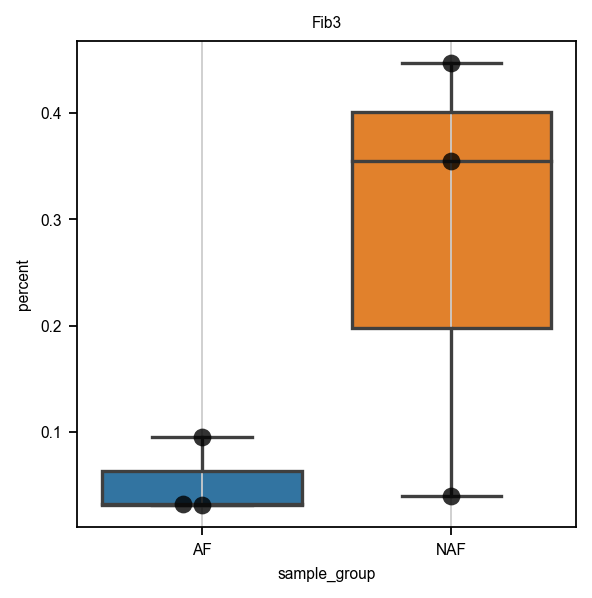

In [10]:
for ct in cts:
    fig = plt.figure()
    sns.boxplot(x='sample_group', y='percent',
                  data=df[df['leiden_poly']==ct],
               )
    sns.swarmplot(x='sample_group', y='percent',
                  data=df[df['leiden_poly']==ct],color ='k',size = 8,alpha = 0.8)
    plt.title(ct)
    plt.grid()
    plt.savefig('./{}_boxplot.jpg'.format(ct),dpi=400)
    

In [56]:
for ct in cts:
    af = list(df[(df['leiden_poly']==ct)&(df['sample_group']=='AF')]['percent'])
    naf = list(df[(df['leiden_poly']==ct)&(df['sample_group']=='NAF')]['percent'])
    print('{} \'s pvals is : {}'.format(ct, stats.ttest_ind(a=af, b=naf, equal_var=True,
                                                            
                                                            alternative='two-sided')[1]))
  

Macro1 's pvals is : 0.2929615888946358
Macro2 's pvals is : 0.7411293575013216
Macro3 's pvals is : 0.7559577506020241
